It looks like you might be running this notebook in Colab! If you want to enable GPU acceleration, ensure you select a GPU runtime in the top-right dropdown menu 🔥

# Fine-tuning
> **FYI**, you can open this documentation as a [Google Colab notebook](https://colab.research.google.com/github/jla-gardner/graph-pes/blob/main/docs/source/quickstart/fine-tuning.ipynb) to follow along interactively

`graph-pes` provides access to several foundation models (with more being added as they are released) for you to use as-is, as well as to fine-tune on your own dataset.
See the [documentation](https://jla-gardner.github.io/graph-pes/interfaces/mace.html#mace-torch) for a growing list of the interfaces we provide.

Below, we:
- install the relevant packages to use the [MACE-MP-0](https://github.com/ACEsuit/mace?tab=readme-ov-file#pretrained-foundation-models) and [Orb](https://github.com/orbital-materials/orb-models) families of models
- fine-tune the model on structures labelled *with a different level of theory*

Since ``graph-pes`` provides a unified interface to many different foundation models, swapping between these different foundation models is incredibly simple!

## Installation

To make use of the `MACE-MP-0` and `Orb` families of models, we need to install `mace-torch` and `orb-models` alongside `graph-pes`:

In [ ]:
!pip install graph-pes mace-torch orb-models

## Loading and using foundation models

Let's start by loading the `MACE-MP-0-small` model and using it to make predictions on some SiO$_2$ structures. To do this, we'll use [load-atoms](https://jla-gardner.github.io/load-atoms/) to download the [SiO2-GAP-22](https://jla-gardner.github.io/load-atoms/datasets/SiO2-GAP-22.html) dataset.

In [1]:
from load_atoms import load_dataset

dataset = load_dataset("SiO2-GAP-22")
dataset

Output()

SiO2-GAP-22:
    structures: 3,074
    atoms: 268,118
    species:
        O: 66.47%
        Si: 33.53%
    properties:
        per atom: (forces)
        per structure: (config_type, energy, stress, virial)

Let's select the first structre from this dataset and visualise it:


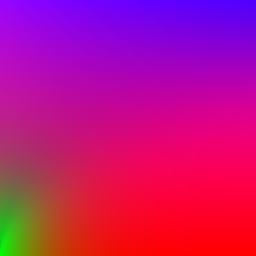

In [2]:
from load_atoms import view

structure = dataset[0]
view(structure, show_bonds=True)

Now that we have a structure, lets use the [graph_pes.interfaces.mace_mp](https://jla-gardner.github.io/graph-pes/interfaces/mace.html#graph_pes.interfaces.mace_mp) function to load the `MACE-MP-0-small` model to make some predictions:

In [3]:
import torch
from graph_pes.interfaces import mace_mp

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

mp0 = mace_mp("small").eval().to(device)
sum(p.numel() for p in mp0.parameters())

Using device: cpu


3847696

This `model` object is a [GraphPESModel](https://jla-gardner.github.io/graph-pes/models/root.html) instance, and so can be used throughout the rest of the `graph-pes` ecosystem. For instance, we can inspect the dimer curves for this model:

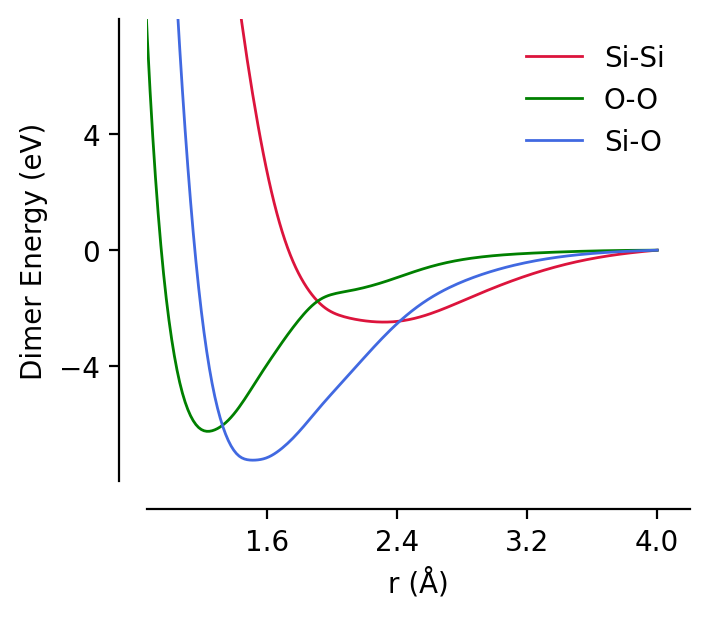

In [4]:
from graph_pes.utils.analysis import dimer_curve
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

for dimer, c in [("Si-Si", "crimson"), ("O-O", "green"), ("Si-O", "royalblue")]: 
    dimer_curve(
        mp0, dimer.replace("-", ""), units="eV", rmin=0.7, rmax=4.0, label=dimer, c=c
    )
plt.legend();

... and also use it as an ASE calculator to generate force predictions:

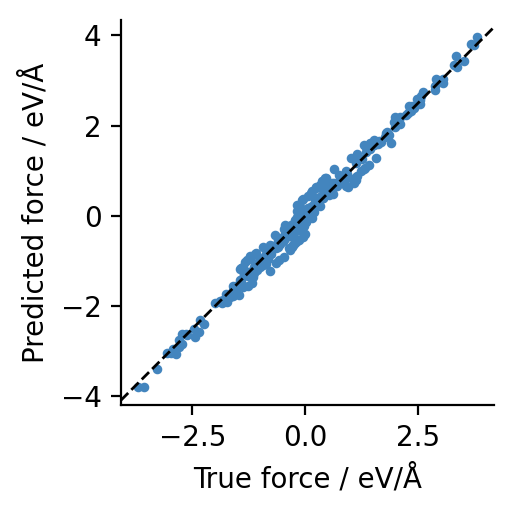

In [5]:
from ase import Atoms
from graph_pes.graph_pes_model import GraphPESModel


def check_forces(model: GraphPESModel, structure: Atoms):
    # make an ASE calculator
    calculator = model.ase_calculator()

    force_predictions = calculator.get_forces(structure)
    force_labels = structure.arrays["forces"]

    plt.figure(figsize=(2.5, 2.5))
    plt.scatter(force_labels.flatten(), force_predictions.flatten(), s=6)
    plt.axline((0, 0), slope=1, color="black", ls="--", lw=1)
    plt.gca().set_aspect("equal")
    plt.xlabel("True force / eV/Å")
    plt.ylabel("Predicted force / eV/Å");


check_forces(mp0, dataset[0])

To demonstrate the architecture-agnostic nature of ``graph-pes``, we can swap between the `MACE-MP-0-small` and `Orb-v3-small` models very easily:

In [6]:
from graph_pes.interfaces import orb_model

orbv2_xs = orb_model("orb-d3-xs-v2").eval().to(device)
sum(p.numel() for p in orbv2_xs.parameters())

9443981

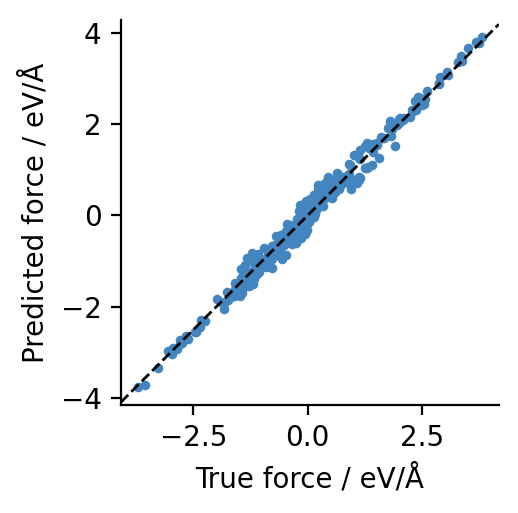

In [7]:
check_forces(orbv2_xs, dataset[0])

It is explicitly not the point here to compare these two models. Instead, we are just demonstrating that these two models, created by different teams and originating from different packages, can be treated identically within the confines of ``graph-pes``.

We now know how to use these foundation models out of the box - they behave just like any other ``graph-pes`` model!

## Fine-tuning

Often we want to fine-tune foundation models on specific datasets to further improve their accuracy. `graph-pes` makes this easy!

We saw above that the *force* predictions for the foundation models were already in close agreement with the DFT labels of the `SiO2-GAP-22` model. This is despite the fact that these foundation models were trained on data labelled with different functionals.

However, different functionals tend to have different "reference" energies, *i.e.*, the energy of an isolated atom of element $X$ will have some non-0 energy, $\varepsilon_X$ and for functional (a) vs (b), $\varepsilon_X^{(a)} \neq \varepsilon_X^{(b)}$.

To demonstrate this, we create an energy parity plot below:

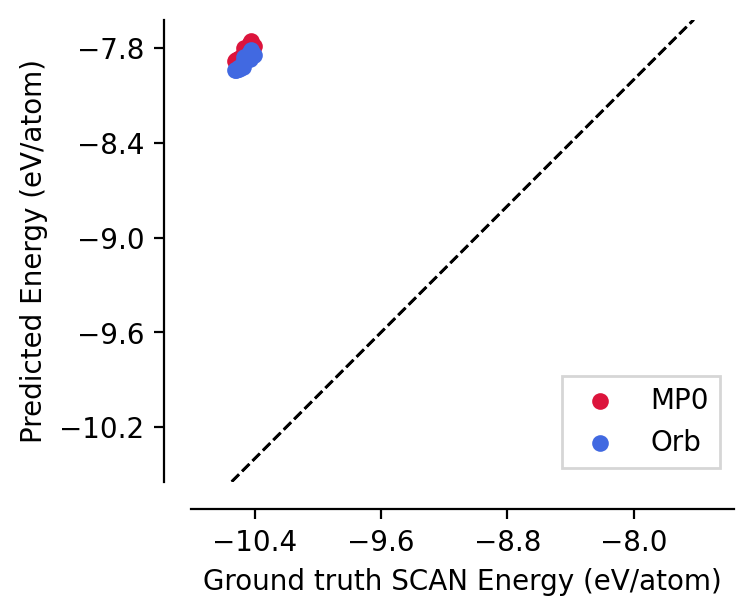

In [8]:
from graph_pes.utils.analysis import parity_plot

parity_plot(
    mp0,
    dataset[:20],
    property="energy_per_atom",
    units="eV/atom",
    c="crimson",
    label="MP0"
)
parity_plot(
    orbv2_xs,
    dataset[:20],
    property="energy_per_atom",
    units="eV/atom",
    c="royalblue",
    label="Orb"
)
plt.xlabel("Ground truth SCAN Energy (eV/atom)")
plt.ylabel("Predicted Energy (eV/atom)")
plt.legend(frameon=True);

`graph-pes` provides automated functionality to correct for exactly these kind of differences:

[graph-pes INFO]: 
Attempting to automatically detect the offset energy for each element.
We do this by first generating predictions for each training structure 
(up to `config.fitting.max_n_pre_fit` if specified). 
This is a slow process! If you already know the reference energies (or the
difference in reference energies if you are fine-tuning an existing model to a
different level of theory), 
we recommend setting `config.fitting.auto_fit_reference_energies` to `False`
and manually specifying a `LearnableOffset` component of your model.

See the "Fine-tuning" tutorial in the docs for more information: 
https://jla-gardner.github.io/graph-pes/quickstart/fine-tuning.html

[graph-pes WARNING]: 
We are attempting to guess the mean per-element
contribution for a per-structure quantity (usually
the total energy). 

However, the composition of the training set is such that 
no unique solution is possible. 

This is probably because you are training on structures
all with the same compositio

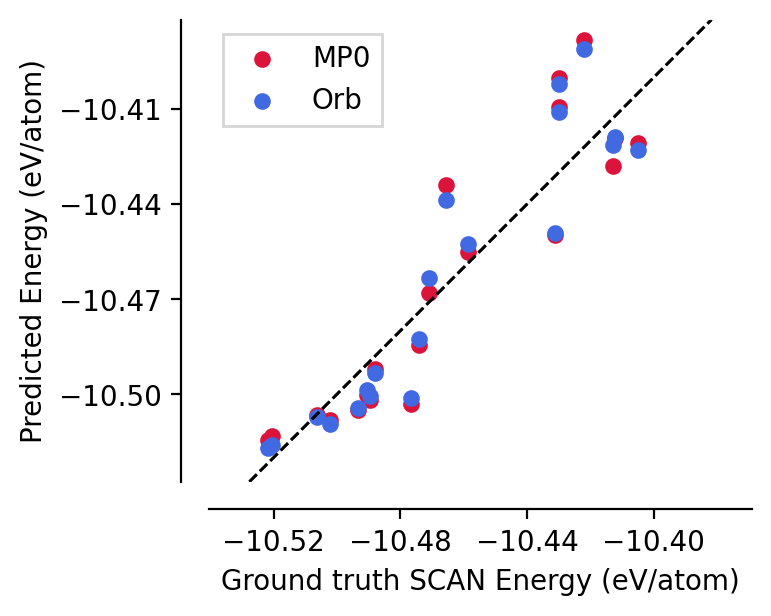

In [9]:
from graph_pes.utils.shift_and_scale import add_auto_offset

adjusted_mp0 = add_auto_offset(mp0, dataset[:20])
adjusted_orb = add_auto_offset(orbv2_xs, dataset[:20])
parity_plot(
    adjusted_mp0,
    dataset[:20],
    property="energy_per_atom",
    units="eV/atom",
    c="crimson",
    label="MP0"
)
parity_plot(
    adjusted_orb,
    dataset[:20],
    property="energy_per_atom",
    units="eV/atom",
    c="royalblue",
    label="Orb"
)
plt.xlabel("Ground truth SCAN Energy (eV/atom)")
plt.ylabel("Predicted Energy (eV/atom)")
plt.legend(frameon=True);


Note the warning above! It we pass a set of structures with exactly the same composition (here $n\cdot SiO_2$), its not possible to decouple the differences in the $\varepsilon_O$ and $\varepsilon_{Si}$. This means if you use this new model to predict energies on a new structure with a different compositions, e.g. $Si_5O_9$, you will get very different energies from what the ground truth can give you.

With that in mind, lets get down to fine-tuning a model. As in our other [fine-tuning guide](https://jla-gardner.github.io/graph-pes/quickstart/quickstart.html#Fine-tuning) we start by selecting some structures to fine-tune on:

In [10]:
train, valid = dataset[:20], dataset[20:25]
train.write("train.xyz")
valid.write("valid.xyz")

Next, we define a config file to describe how what and how we want to fine-tune. Two vital features here are:
1. the `fitting/auto_fit_reference_energies=true` flag - this performs the above automated offset guessing before any fine-tuning takes place
2. using a relatively small learning rate 

In [20]:
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
cutoff = mp0.cutoff.item()

training_config = f"""
data:
    train:
        +file_dataset: 
            path: train.xyz
            cutoff: {cutoff}
    valid:
        +file_dataset: 
            path: valid.xyz
            cutoff: {cutoff}

loss:
    - +PerAtomEnergyLoss()
    - +ForceRMSE()

fitting:
    trainer_kwargs:
        max_epochs: 20
        accelerator: {accelerator}

    optimizer:
        +Optimizer:
            name: Adam
            lr: 0.0001

    auto_fit_reference_energies: true              

wandb: null
general:
    progress: logged
    run_id: mp0-fine-tune
"""

mp0_config = """
model:
    +mace_mp:
        model: small

general:
    run_id: mp0-fine-tune
"""

with open("fine-tune.yaml", "w") as f:
    f.write(training_config)

with open("mp0.yaml", "w") as f:
    f.write(mp0_config)

Now we can fine-tune. Note the use of config file stacking here - this lets us separate the config into different files, which can often be useful! (see below)

In [12]:
!graph-pes-train fine-tune.yaml mp0.yaml

[graph-pes INFO]: Started `graph-pes-train` at 2025-04-11 16:52:15.879
[graph-pes INFO]: Successfully parsed config.
[graph-pes INFO]: Logging to graph-pes-results/mp0-fine-tune/rank-0.log
[graph-pes INFO]: ID for this training run: mp0-fine-tune
[graph-pes INFO]: 
Output for this training run can be found at:
   └─ graph-pes-results/mp0-fine-tune
      ├─ rank-0.log         # find a verbose log here
      ├─ model.pt           # the best model (according to valid/loss/total)
      ├─ lammps_model.pt    # the best model deployed to LAMMPS
      ├─ train-config.yaml  # the complete config used for this run
      └─ summary.yaml       # the summary of the training run

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[graph-pes INFO]: Preparing data
[graph-pes INFO]: Setting up datasets
[graph-pes INFO]: Pre-fitting the model on 20 samples
[graph-pes INFO]: 
Attempting to automatically detect the offset energy for each el

Nice! Fine-tuning on just 20 structures has brought the validation error down significantly 😊 Of course in real life, one would train for longer, and perhaps make use of early stopping to prevent overfitting to the small amounts of data - see the [docs](https://jla-gardner.github.io/graph-pes/cli/graph-pes-train/complete-docs.html) for the relevant config options you need to pass to do that.

Lets load in our fine-tuned model and check that everything is working as expected:

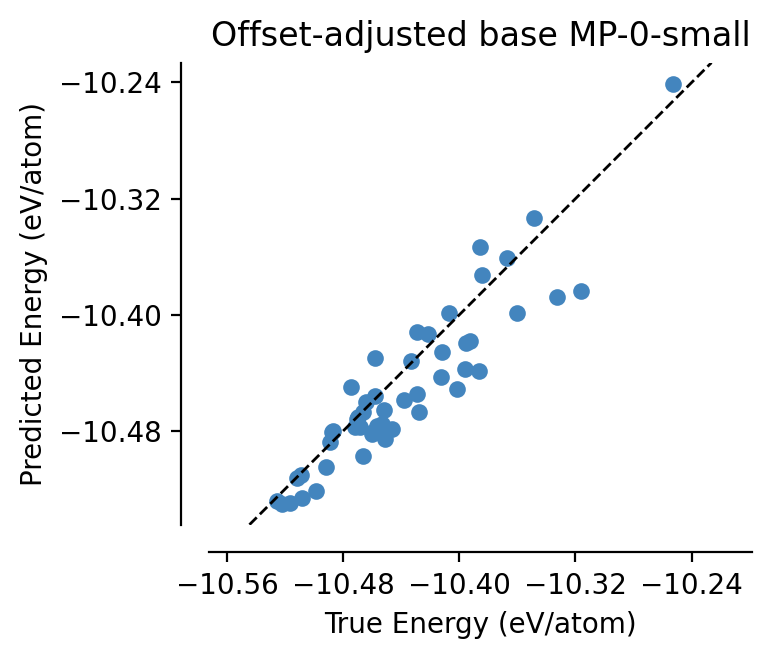

Text(0.5, 1.0, 'Fine-tuned MP-0-small')

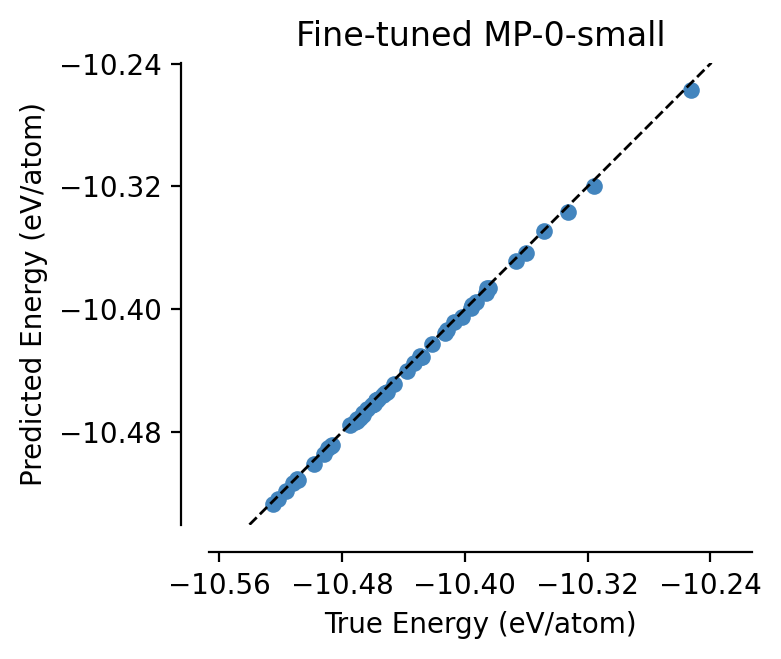

In [13]:
from graph_pes.models import load_model

test_set = dataset[50:100]

parity_plot(
    adjusted_mp0,
    test_set,
    property="energy_per_atom",
    units="eV/atom",
)
plt.title("Offset-adjusted base MP-0-small")
plt.show()

fine_tuned_mp0 = load_model("graph-pes-results/mp0-fine-tune/model.pt").eval()
parity_plot(
    fine_tuned_mp0,
    test_set,
    property="energy_per_atom",
    units="eV/atom",
)
plt.title("Fine-tuned MP-0-small")

Swapping out the ``MP-0`` model for the ``Orb`` model is trivial! We just need to change the model definition in the config file. Here we're being extra fancy, and freezing all the model parameters except those in the read-out head (see [graph_pes.models.freeze_all_except](https://jla-gardner.github.io/graph-pes/models/root.html#graph_pes.models.freeze_all_except) for details):

In [24]:
orb_config = """
model:
    +freeze_all_except:
        model:
            +orb_model:
                name: orb-d3-xs-v2
        pattern: _orb\\.heads.*

general:
    run_id: orb-fine-tune
"""

with open("orb.yaml", "w") as f:
    f.write(orb_config)

In [25]:
!graph-pes-train fine-tune.yaml orb.yaml

/opt/miniconda3/envs/mace/lib/python3.11/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
[graph-pes INFO]: Started `graph-pes-train` at 2025-04-11 17:16:02.923
/opt/miniconda3/envs/mace/lib/python3.11/site-packages/orb_models/utils.py:30: UserWarning: Setting global torch default dtype to torch.float32.
  warnings.warn(f"Setting global torch default dtype to {torch_dtype}.")
[graph-pes INFO]: Successfully parsed config.
[graph-pes INFO]: Logging to graph-pes-results/orb-fine-tune/rank-0.log
[graph-pes INFO]: ID for this training run: orb-fine-tune
[graph-pes INFO]: 
Output for this training run can be found at:
   └─ graph-pes-results/orb-fine-tune
      ├─ rank-0.log         # find a verbose log here
      ├─ model.pt 

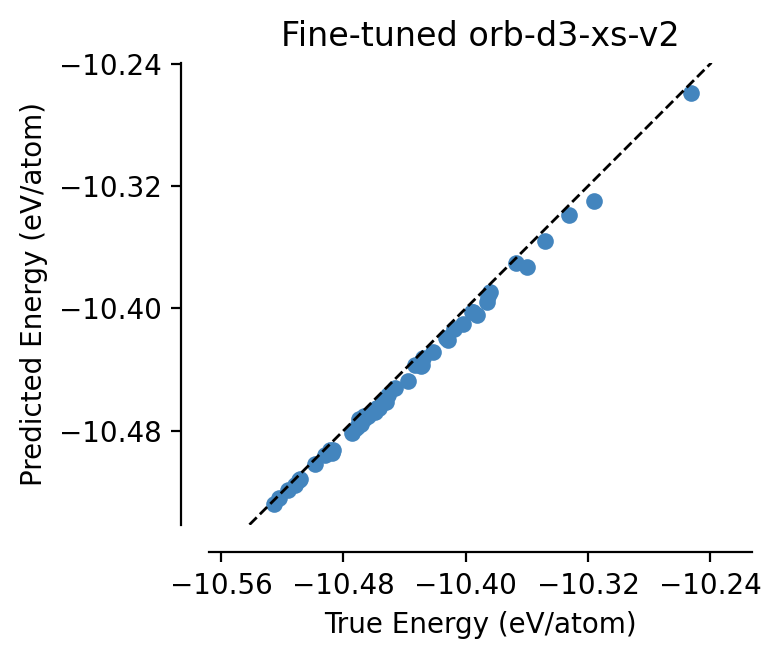

In [26]:
fine_tuned_orb = load_model("graph-pes-results/orb-fine-tune/model.pt").eval()
parity_plot(
    fine_tuned_orb,
    test_set,
    property="energy_per_atom",
    units="eV/atom",
)
plt.title("Fine-tuned orb-d3-xs-v2");

Again, we aren't trying to make direct comparisons between these two models here - the instances we have chosen are both small models to show proof of concept.

If you want to explore fine-tuning various foundation models, we strongly recommend that you tune the hyperparameters of the fine-tuning process for each one separately.

## Fine-tuning other models

Of course, you can also fine-tune other models that you have trained yourself! In this case, rather than using the foundation model interfaces, use the ``load_model`` function to load your model from disk. Remember to pass the ``auto_fit_reference_energies=true`` flag to the ``graph-pes-train`` command to ensure that this model correctly updates its reference energies:

```yaml
model:
    +load_model:
        path: path/to/model.pt

fitting:
    auto_fit_reference_energies: true

# ... <-- other config options as normal
```